<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-import" data-toc-modified-id="Data-import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data import</a></span></li><li><span><a href="#Random-Forest-analysis" data-toc-modified-id="Random-Forest-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Random Forest analysis</a></span><ul class="toc-item"><li><span><a href="#get-the-X-and-y-arrays" data-toc-modified-id="get-the-X-and-y-arrays-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>get the X and y arrays</a></span></li><li><span><a href="#Extract-feature-importance-from-the-RF-runs" data-toc-modified-id="Extract-feature-importance-from-the-RF-runs-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Extract feature importance from the RF runs</a></span></li><li><span><a href="#Permutations-to-extract-p-values-for-each-feature-importance" data-toc-modified-id="Permutations-to-extract-p-values-for-each-feature-importance-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Permutations to extract p-values for each feature importance</a></span></li><li><span><a href="#Calculate-p-values" data-toc-modified-id="Calculate-p-values-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Calculate p-values</a></span></li><li><span><a href="#Write-final-results-to-file" data-toc-modified-id="Write-final-results-to-file-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Write final results to file</a></span></li></ul></li><li><span><a href="#Plots-(heatmap-and-sum-by-class)" data-toc-modified-id="Plots-(heatmap-and-sum-by-class)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plots (heatmap and sum by class)</a></span><ul class="toc-item"><li><span><a href="#Heatmap" data-toc-modified-id="Heatmap-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Heatmap</a></span></li><li><span><a href="#Make-plots-for-each-candidate-summing-over-the-class" data-toc-modified-id="Make-plots-for-each-candidate-summing-over-the-class-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Make plots for each candidate summing over the class</a></span></li></ul></li><li><span><a href="#Step-wise-selection" data-toc-modified-id="Step-wise-selection-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Step-wise selection</a></span><ul class="toc-item"><li><span><a href="#Find-candidates-to-be-removed" data-toc-modified-id="Find-candidates-to-be-removed-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Find candidates to be removed</a></span></li><li><span><a href="#Random-Forest-run" data-toc-modified-id="Random-Forest-run-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Random Forest run</a></span></li><li><span><a href="#Permutations" data-toc-modified-id="Permutations-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Permutations</a></span></li><li><span><a href="#p-values" data-toc-modified-id="p-values-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>p-values</a></span></li></ul></li><li><span><a href="#Plots" data-toc-modified-id="Plots-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plots</a></span></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import random 

# custom functions
from helper_functions import extract_feature_importance_avg_and_sd_from_multiple_random_forest_runs
from helper_functions import extract_feature_importances_from_random_forests_on_permuted_y
from helper_functions import get_significant_features
from helper_functions import plot_candidate_heatmap
from helper_functions import plot_candidate_sum_by_class
from helper_functions import get_sum_by_class_df

# Data import

In [2]:
df = pd.read_csv("pheno_terpenoids.tsv",sep="\t",index_col=0)

# Random Forest analysis 

## get the X and y arrays

In [3]:
# get whitefly classes
y = df["wf"].tolist()
stratify_info = df['wf'].map({'non-toxic': 0, 'toxic': 1})

# get matrix X of volatile values
X = df.iloc[:,2:]

## Extract feature importance from the RF runs

In [4]:
# generates a list with two elements
# first element average feature importance
# and second element standard deviation
feature_importances = extract_feature_importance_avg_and_sd_from_multiple_random_forest_runs(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nb_of_runs=5,
    njobs=2
)

## Permutations to extract p-values for each feature importance

In [5]:
# compute feature importances based on permuted y values
feature_importance_perm = extract_feature_importances_from_random_forests_on_permuted_y(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nperm=100,
    njobs=3
)

## Calculate p-values

**How?** By comparing the average feature importance from the original dataset to the distribution of feature importance based on N permutations.   

In [6]:
all_pvalues = get_significant_features(X,
                                  original_feature_importances=feature_importances,
                                  permuted_feature_importances=feature_importance_perm,
                                  pval=0.05)
all_pvalues.head()

,p-value,average,sd,rsd
5.541_67.0557,0.0344828,0.004201,0.001203,0.286328
7.060_95.0168,0.45977,0.002420,0.001424,0.588276
9.272_93.0728,0.229885,0.003766,0.002145,0.569687
9.472_91.0566,0.137931,0.003392,0.001825,0.537992
9.653_91.0565,0.275862,0.045564,0.008816,0.193498


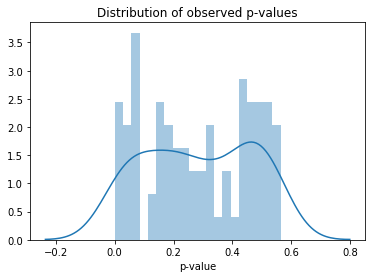

In [7]:
sns.distplot(all_pvalues.iloc[:,0].astype('float'),20)
plt.title('Distribution of observed p-values');

## Write final results to file

In [8]:
# Select significant variables
signif = all_pvalues.loc[all_pvalues.iloc[:,0]<0.05,:]

# write to table
signif.to_csv("Table.volatiles_and_thrips.tsv",sep="\t")

# Plots (heatmap and sum by class)

## Heatmap
To display a heatmap that shows the rows of the non-toxic genotypes followed by the rows of the toxic genotypes.

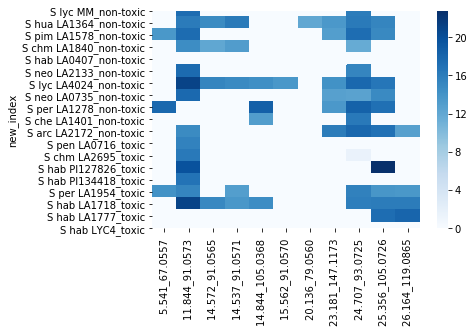

In [9]:
# drops the thrips columns
df_wf = df.drop("thrips",axis=1) 

# plot
plot_candidate_heatmap(
    df=df_wf,
    class_col="wf",
    significant=signif.index.values,
    log=True
)

## Make plots for each candidate summing over the class

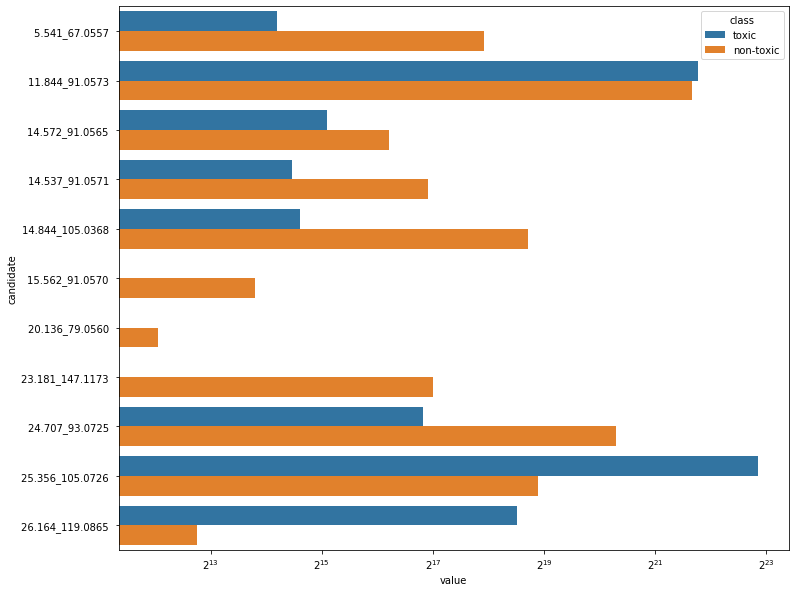

In [10]:
plot_candidate_sum_by_class(
    df = df_wf,
    class_col = "wf",
    significant=signif.index.values
)

# Step-wise selection

This analysis is different because we will use a filtered dataset based on the results using the original, non-filtered dataset.

Significant volatiles that are only detected in the whitefly *non-toxic* class are taken out from the original dataset. That is, their abundance in the *toxic* class should be equal to 0 (not detected in the toxic genotypes).

Indeed, these volatiles are too discriminant between the two classes and thus these volatiles get a very high feature importance. As the goal of this analysis is also to get significant volatiles that are either present in both classes (but quantitatively different) or only detectable in the *toxic* class. 

**Which of the candidate have a value close to 0 in the toxic class but a value > 0 in the non-toxic class?**
To answer this, I can calculate the ratio of the candidates abundances in the non-toxic class and divide it by its abundance in the toxic class. A high ratio would suggest that the compound is almost exclusively present in the non-toxic genotypes. 

## Find candidates to be removed

In [11]:
# getting candidates with a high non-toxic to toxic ratio
ratio_threshold = 100

In [12]:
# get the sumByClass dataframe
sumByClass = get_sum_by_class_df(df_wf,class_col="wf",significant=signif.index.values)

# first pivoting (unmelting) the sumByClass dataframe
sumByClass_reshaped = sumByClass.pivot(index="candidate",columns="class",values="value")

# calculating the ratio 
sumByClass_reshaped["ratio"] = sumByClass_reshaped["non-toxic"] / sumByClass_reshaped["toxic"]

candidates_to_drop = sumByClass_reshaped[sumByClass_reshaped["ratio"] > ratio_threshold].index.get_values().tolist()

In [13]:
# read original dataframe
df = pd.read_csv("pheno_terpenoids.tsv",sep="\t",index_col=0)
print("original dimensions:",df.shape)
df = df.drop(columns=candidates_to_drop)
print("After dropping variables: dimensions:",df.shape)

original dimensions: (19, 89)
After dropping variables: dimensions: (19, 86)


## Random Forest run 

In [14]:
# get whitefly classes
y = df["wf"].tolist()
stratify_info = df['wf'].map({'non-toxic': 0, 'toxic': 1})

# get matrix X of volatile values
X = df.iloc[:,2:]

In [15]:
# generates a list with two elements
# first element average feature importance
# and second element standard deviation
feature_importances = extract_feature_importance_avg_and_sd_from_multiple_random_forest_runs(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nb_of_runs=5,
    njobs=2
)

## Permutations

In [16]:
# compute feature importances based on permuted y values
feature_importance_perm = extract_feature_importances_from_random_forests_on_permuted_y(
    X,
    y,
    nb_of_splits=6,
    nb_of_trees=1000,
    nperm=100,
    njobs=3
)

## p-values

In [17]:
all_pvalues = get_significant_features(X,
                                  original_feature_importances=feature_importances,
                                  permuted_feature_importances=feature_importance_perm,
                                  pval=0.05)

# Plots